In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

df = pd.read_csv('/supply_chain_data.csv') #загрузка данных

print(df.head())

  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [17]:
#переименовываю колонки по зависимому фактору Y и потенциальным факторам Xi
df.rename(columns={
    'Number of products sold': 'Y',
    'Price': 'X1_Price',
    'Order quantities': 'X2_OrdQty',
    'Production volumes': 'X3_Production'
}, inplace=True)
print(df[['Y', 'X1_Price', 'X2_OrdQty', 'X3_Production']].head())

     Y   X1_Price  X2_OrdQty  X3_Production
0  802  69.808006         96            215
1  736  14.843523         37            517
2    8  11.319683         88            971
3   83  61.163343         59            937
4  871   4.805496         56            414


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_model = df[['Y', 'X1_Price', 'X2_OrdQty', 'X3_Production']].dropna() #удаление строк с пропусками в этих колонках
X = df_model[['X1_Price', 'X2_OrdQty', 'X3_Production']].values
Y = df_model['Y'].values #матрица признаков X и Y

#модель множественной линейной регрессии
model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

#вывод метрик
r2 = r2_score(Y, Y_pred)
MSE = mean_squared_error(Y, Y_pred)
print(f"R² = {r2:.4f}")
print(f"MSE = {MSE:.4f}")

#показатель системного эффекта факторов доля объяснённой дисперсии (R²) / доля необъяснённой (1−R²)
systemic_effect = r2 / (1 - r2)
print(f"Системный эффект факторов = {systemic_effect:.4f}")

R² = 0.0371
MSE = 87971.4570
Системный эффект факторов = 0.0385


In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor #импорт функции для расчёта меры мультиколлинеарности

#добавление константы для Х столбца
X_const = sm.add_constant(df_model[['X1_Price', 'X2_OrdQty', 'X3_Production']])

# мера мультколлинеарности для каждого столбца (константа и факторы)
vif_data = pd.DataFrame({
    'Признак': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print("\nМультиколлинеарность (VIF):")
print(vif_data)


Мультиколлинеарность (VIF):
         Признак        VIF
0          const  12.804213
1       X1_Price   1.023337
2      X2_OrdQty   1.015062
3  X3_Production   1.021597


Корреляционная матрица:
                       Y  X1_Price  X2_OrdQty  X3_Production
Y              1.000000  0.005739   0.015992       0.187945
X1_Price       0.005739  1.000000   0.095819      -0.124575
X2_OrdQty      0.015992  0.095819   1.000000      -0.086567
X3_Production  0.187945 -0.124575  -0.086567       1.000000


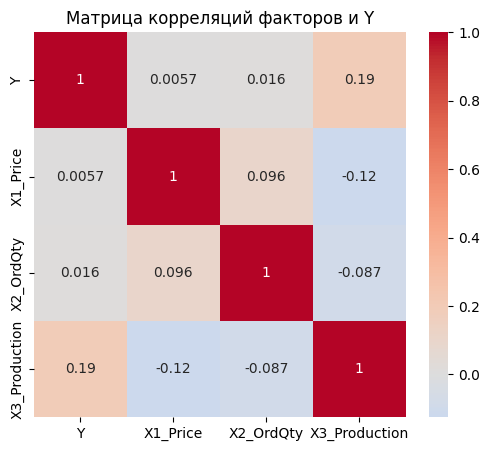


P-values:
 X1_Price         0.790392
X2_OrdQty        0.765419
X3_Production    0.058377
dtype: float64

Выбранные факторы: ['X3_Production', 'X2_OrdQty']


In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

#запрос для корреляционной матрицы
corr_matrix = df_model.corr()
print("Корреляционная матрица:\n", corr_matrix)

#построение графика
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций факторов и Y')
plt.show()

# оценка p-values
X = sm.add_constant(df_model[['X1_Price','X2_OrdQty','X3_Production']]) #добавление константы к матрице признаков
model = sm.OLS(df_model['Y'], X).fit() #модель метода наименьших квадратов для того, чтобы найти p-value
p_values = model.pvalues.drop('const')
print("\nP-values:\n", p_values)

# выбор факторов с p-value < 0.05
sig = p_values[p_values < 0.05].index.tolist()
if len(sig) < 2:
    sig = p_values.sort_values().index[:2].tolist()
print("\nВыбранные факторы:", sig)

In [63]:
Y_true = df_model['Y']  # вектор истинных значений Y


# старая модель
Y_true = df_model['Y']
Y_pred_all = model.predict(X)
r2_all = r2_score(Y_true, Y_pred_all)
mse_all = mean_squared_error(Y_true, Y_pred_all)

#новая модель с только значимыми факторами
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

X_sig = sm.add_constant(df_model[sig]) # матрица признаков со значимыми факторами
model2 = sm.OLS(Y_true, X_sig).fit()# строим OLS-модель
Y_pred_sig = model2.predict(X_sig)# предсказания

r2_sig = r2_score(Y_true, Y_pred_sig)# считаем R²
mse_sig = mean_squared_error(Y_true, Y_pred_sig)# считаем MSE

print(f"R² = {r2_sig:.4f}")
print(f"MSE = {mse_sig:.4f}")

print(f"\nМодель 1 (все):  R²={r2_all:.3f}, MSE={mse_all:.3f}")
print(f"Модель 2 (sig):  R²={r2_sig:.3f}, MSE={mse_sig:.3f}")
print(f"ΔR²={r2_sig-r2_all:+.3f}, ΔMSE={mse_sig-mse_all:+.3f}")

R² = 0.0364
MSE = 88036.5614

Модель 1 (все):  R²=0.037, MSE=87971.457
Модель 2 (sig):  R²=0.036, MSE=88036.561
ΔR²=-0.001, ΔMSE=+65.104


In [69]:
import numpy as np
from scipy import stats

#задаем признаки
Y_true = df_model['Y'].values
X_all = df_model[['X1_Price','X2_OrdQty','X3_Production']].values
X_sig = df_model[sig].values

#количество наблюдений и факторов
n = len(Y_true)
k1 = X_all.shape[1] - 1  #число факторов в полной модели (без константы)
k2 = X_sig.shape[1] - 1  #число факторов в сокращённой модели

#суммы квадратов остатка
rss1 = np.sum((Y_true - Y_pred_all)**2)
rss2 = np.sum((Y_true - Y_pred_sig)**2)

# F-статистика
F_stat = ((rss2 - rss1) / (k1 - k2)) / (rss1 / (n - k1 - 1))

# Критическое значение и p-value
alpha = 0.05
F_crit = stats.f.ppf(1 - alpha, dfn=(k1 - k2), dfd=(n - k1 - 1))
p_value = 1 - stats.f.cdf(F_stat, dfn=(k1 - k2), dfd=(n - k1 - 1))

# Вывод
print(f"F-статистика = {F_stat:.4f}")
print(f"F-критическое (α={alpha}) = {F_crit:.4f}")
print(f"p-value = {p_value:.4f}")
if F_stat < F_crit:
    print("Исключение факторов целесообразно.")
else:
    print("Исключение факторов нецелесообразно.")

F-статистика = 0.0718
F-критическое (α=0.05) = 3.9391
p-value = 0.7893
Исключение факторов целесообразно.


In [83]:
residuals = Y_true - Y_pred_sig  # вектор остатков

import numpy as np
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

#тест поворотных точек (случайность остатков)
def turning_points(res):
    tp = 0
    for i in range(1, len(res) - 1):
        if (res[i] > res[i - 1] and res[i] > res[i + 1]) or \
           (res[i] < res[i - 1] and res[i] < res[i + 1]):
            tp += 1
    n = len(res)
    E_tp = 2 * (n - 2) / 3
    V_tp = (16 * n - 29) / 90
    z = (tp - E_tp) / np.sqrt(V_tp)
    p_tp = 2 * (1 - stats.norm.cdf(abs(z)))
    return tp, z, p_tp

tp, z_tp, p_tp = turning_points(residuals)
print(f"Поворотные точки: {tp}, Z={z_tp:.3f}, p={p_tp:.3f}")

#асимметрия и эксцесс остатков
skew = stats.skew(residuals)
kurt = stats.kurtosis(residuals)
_, p_norm = stats.normaltest(residuals)
print(f"Асимметрия={skew:.3f}, Эксцесс={kurt:.3f}, тест нормальности p={p_norm:.3f}")

#критерий Дарбина–Уотсона
dw = durbin_watson(residuals)
print(f"Дарбин-Уотсон={dw:.3f}")

#t-тест для суммы остатков = 0
t_stat, p_t = stats.ttest_1samp(residuals, 0)
print(f"t={t_stat:.4f}, p={p_t:.4f}")

Поворотные точки: 60, Z=-1.277, p=0.202
Асимметрия=0.155, Эксцесс=-1.211, тест нормальности p=0.000
Дарбин-Уотсон=2.066
t=-0.0000, p=1.0000
